In [1]:
card_type = "Spades"
model = "lstm"

In [2]:
# Parameters
card_type = "Clubs"
model = "lstm"


In [3]:
import pandas as pd
import numpy as np
from chance_utils import compute_statistics
from matplotlib import pyplot as plt

In [4]:
possible_result = ["7","8","9","10","J","Q","K","A"]
n_outputs = 8
n_features = 8
sample_length = 240*5

In [5]:
dummies = pd.get_dummies(possible_result).T
dummies = dummies.reindex(index=possible_result,fill_value=0)
dummies = dummies.reset_index()
dummies

,index,0,1,2,3,4,5,6,7
0,7,1,0,0,0,0,0,0,0
1,8,0,1,0,0,0,0,0,0
2,9,0,0,1,0,0,0,0,0
3,10,0,0,0,1,0,0,0,0
4,J,0,0,0,0,1,0,0,0
5,Q,0,0,0,0,0,1,0,0
6,K,0,0,0,0,0,0,1,0
7,A,0,0,0,0,0,0,0,1


In [6]:
test_chance = pd.read_csv("test_chance.csv",index_col=[0])
test_chance.Date = pd.to_datetime(test_chance.Date)

train_chance = pd.read_csv('train_chance.csv',index_col=[0])
train_chance.Date = pd.to_datetime(train_chance.Date)

In [7]:
spades_test_chance = test_chance[['Date',card_type]]
spades_test_chance = pd.merge(dummies,spades_test_chance,left_on='index',right_on=card_type,how="right").drop(columns="index")

spades_train_chance = train_chance[['Date',card_type]]
spades_train_chance = pd.merge(dummies,spades_train_chance,left_on='index',right_on=card_type,how="right").drop(columns="index")
spades_train_chance.head()

,0,1,2,3,4,5,6,7,Date,Clubs
0,0,0,0,0,0,1,0,0,2001-01-01 00:00:00.006820,Q
1,0,0,1,0,0,0,0,0,2001-01-01 00:00:00.006821,9
2,0,0,0,1,0,0,0,0,2001-01-01 00:00:00.006822,10
3,0,0,0,0,0,0,0,1,2001-01-01 00:00:00.006823,A
4,0,0,0,0,0,0,1,0,2001-02-01 00:00:00.006824,K


In [8]:
# make the samples ready to tsfresh
spades_test_chance = spades_test_chance.sort_values(by="Date").reset_index(drop=True)
spades_test_chance['id'] = 1

spades_train_chance = spades_train_chance.sort_values(by="Date").reset_index(drop=True)
spades_train_chance['id'] = 1

spades_train_chance.tail()

,0,1,2,3,4,5,6,7,Date,Clubs,id
29119,0,0,0,1,0,0,0,0,2017-12-07 00:00:00.035924,10,1
29120,1,0,0,0,0,0,0,0,2017-12-07 00:00:00.035925,7,1
29121,0,0,0,0,0,0,0,1,2017-12-07 00:00:00.035926,A,1
29122,0,0,0,1,0,0,0,0,2017-12-07 00:00:00.035927,10,1
29123,0,0,0,0,0,1,0,0,2017-12-07 00:00:00.035928,Q,1


In [9]:
from tsfresh.utilities.dataframe_functions import roll_time_series

df_test_rolled = roll_time_series(spades_test_chance, column_id="id",column_sort="Date",max_timeshift=sample_length-1,min_timeshift=sample_length-1)
df_train_rolled = roll_time_series(spades_train_chance, column_id="id",column_sort="Date",max_timeshift=sample_length-1,min_timeshift=sample_length-1)
df_train_rolled.tail()

/Users/serlich/Documents/Notebooks/env/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]
/Users/serlich/Documents/Notebooks/env/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


,0,1,2,3,4,5,6,7,Date,Clubs,id
33509995,0,0,0,1,0,0,0,0,2017-12-07 00:00:00.035924,10,"(1, 2017-12-07 00:00:00.035928)"
33509996,1,0,0,0,0,0,0,0,2017-12-07 00:00:00.035925,7,"(1, 2017-12-07 00:00:00.035928)"
33509997,0,0,0,0,0,0,0,1,2017-12-07 00:00:00.035926,A,"(1, 2017-12-07 00:00:00.035928)"
33509998,0,0,0,1,0,0,0,0,2017-12-07 00:00:00.035927,10,"(1, 2017-12-07 00:00:00.035928)"
33509999,0,0,0,0,0,1,0,0,2017-12-07 00:00:00.035928,Q,"(1, 2017-12-07 00:00:00.035928)"


In [10]:
test_labeling_df = test_chance[['lottoryNumber',card_type]]
train_labeling_df = train_chance[['lottoryNumber',card_type]]

labeling_df = pd.concat([test_labeling_df,train_labeling_df])
labeling_df.head()

,lottoryNumber,Clubs
29124,35944,Q
29125,35945,9
29126,35946,9
29127,35947,10
29128,35948,8


In [11]:
def make_a_sample(current_sample,labeling_df):
    
    current_id = current_sample['id'].values[0]
    final_label = None
    
    assert current_sample.shape[0] == sample_length, f"{current_id} is not shape of {sample_length}"

    lottey_num_predicting = (current_id[1].microsecond + 1)
    label = labeling_df[labeling_df.lottoryNumber == lottey_num_predicting][card_type]
    
    if len(label) == 1:
        final_label = label.values[0]

    sample = current_sample.drop(columns=['id','Date',card_type]).values

    return lottey_num_predicting,final_label,sample

In [12]:
train = df_train_rolled.groupby("id").apply(lambda x:make_a_sample(x,labeling_df))

train = sorted(train.values,key=lambda x:x[0])
_,train_y,train_x = map(list, zip(*train))

In [13]:
test = df_test_rolled.groupby("id").apply(lambda x:make_a_sample(x,labeling_df))

test = sorted(test.values,key=lambda x:x[0])
_,test_y,test_x = map(list, zip(*test))

In [14]:
test_x = np.stack(test_x)
test_y = pd.merge(dummies,pd.Series(test_y,name='label'),left_on='index',right_on="label",how="right").drop(columns=["index","label"]).values

train_x = np.stack(train_x)
train_y = pd.merge(dummies,pd.Series(train_y,name='label'),left_on='index',right_on="label",how="right").drop(columns=["index","label"]).values

In [15]:
assert test_x.shape[0] == test_y.shape[0] and train_x.shape[0] == train_y.shape[0]

In [16]:
last_sample = test_x[-1]
test_x = test_x[:-1]
test_y = test_y[:-1]

In [17]:
print(f"Test shape {test_x.shape}")
print(f"Train shape {train_x.shape}")

Test shape (8509, 1200, 8)
Train shape (27925, 1200, 8)


In [18]:
import tensorflow as tf

if model == "lstm":
    #
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(100, input_shape=(sample_length,n_features)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
elif model == "nn":
    #
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(sample_length,8)))
    model.add(tf.keras.layers.Dense(350, activation='relu'))
    model.add(tf.keras.layers.Dense(250, activation='relu'))
    model.add(tf.keras.layers.Dense(150, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))
    model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 8)                 808       
                                                                 
Total params: 54,508
Trainable params: 54,508
Non-trainable params: 0
_________________________________________________________________


2022-08-12 21:29:09.162043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
assert not np.isnan(train_x).any()
assert not np.isnan(train_y).any()
assert not np.isnan(test_x).any()
assert not np.isnan(test_y).any()

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
# 
history = model.fit(train_x,train_y,validation_data=(test_x,test_y),batch_size=64,epochs=300,callbacks=[es])

Epoch 1/300
437/437 [==============================] - 287s 653ms/step - loss: 2.0807 - accuracy: 0.1239 - val_loss: 2.0799 - val_accuracy: 0.1238
Epoch 2/300
437/437 [==============================] - 290s 664ms/step - loss: 2.0797 - accuracy: 0.1315 - val_loss: 2.0801 - val_accuracy: 0.1249
Epoch 3/300
437/437 [==============================] - 281s 642ms/step - loss: 2.0796 - accuracy: 0.1295 - val_loss: 2.0799 - val_accuracy: 0.1322
Epoch 4/300
437/437 [==============================] - 282s 646ms/step - loss: 2.0796 - accuracy: 0.1300 - val_loss: 2.0797 - val_accuracy: 0.1257
Epoch 5/300
437/437 [==============================] - 280s 641ms/step - loss: 2.0790 - accuracy: 0.1320 - val_loss: 2.0801 - val_accuracy: 0.1212
Epoch 6/300
437/437 [==============================] - 276s 632ms/step - loss: 2.0789 - accuracy: 0.1320 - val_loss: 2.0802 - val_accuracy: 0.1259
Epoch 7/300
437/437 [==============================] - 273s 626ms/step - loss: 2.0787 - accuracy: 0.1321 - val_loss: 2

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


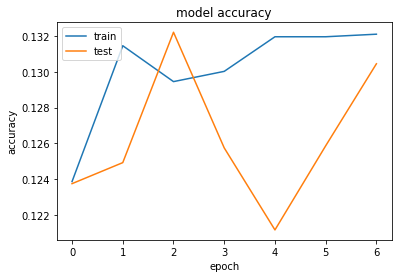

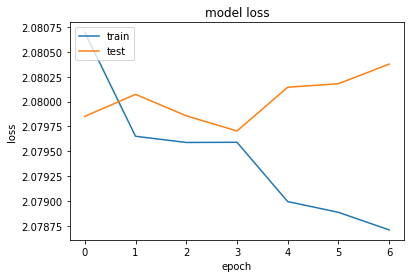

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
predictions = model.predict(test_x)

def get_card_from_encoding(encoding):
    gambels = encoding.argmax(axis=1)
    return np.vectorize(lambda x:possible_result[x])(gambels)

266/266 [==============================] - 28s 104ms/step


In [23]:
predictions_cards = get_card_from_encoding(predictions)
true_cards = get_card_from_encoding(test_y)

compute_statistics(predictions_cards,true_cards)

{'name': UUID('4878a770-42fe-4a67-9d42-bd30f1b6aa00'),
 'invested': '£850,900.00',
 'single_bet_amount': '£100.00',
 'total_invested': '£850,900.00',
 'total_won': 1110,
 'precentage_won': 13.045011164649194,
 'expected_won': 12.5,
 'eraned': '£555,000.00',
 'revenue': '-£295,900.00'}